# Training and Tuning

In thinking of the types of models, or complexity of models, accoutning for the bias-variance tradeoff is necessary.

<img src='BiasVarAnec.png'>

## Model Complexity Graph
<img src='ModelComplexityGraph.png'>

**BIG ISSUE: CANT USE TESTING SET FOR MODEL SELECTION**

Instead, include a **Cross Validation** set
<img src='CrossValSet.png'>

And we can see this graph instead:
<img src='ModelCompCVTrainGraph.png'>

# K-Fold Cross Validation

Break the data into "k" parts/buckets, then train the model k times with each time using a different part/bucket as the testing set and the other parts as the training set, then we average the results to get a final model

```python
from sklearn.model_selection import KFold
kf = KFold(12,3)

for train_indices, test_indices in kf:
    print train_indices, test_indices
    
[3 4 5 6 7 8 9 10 11] [0 1 2]
[0 1 2 6 7 8 9 10 11] [3 4 5]
[0 1 2 3 4 5 6 7 8] [9 10 11]
```

<img src='KFold.png'>

It is good practice to randomize your data for this type of cross validation:

```python
from sklearn.model_selection import KFold
kf = KFold(12,4, shuffle=True)

for train_indices, test_indices in kf:
    print train_indices, test_indices
    
[0 1 2 3 4 5 6 8 11] [7 9 10]
[0 1 2 4 6 7 8 9 10] [3 5 11]
[1 3 5 6 7 8 9 10 11] [0 2 4]
[0 2 3 4 5 7 9 10 11] [1 6 8]
```

<img src='KFoldShuffle.png'>

# Learning Curves

Test if you are under or over fitting. Change the training points and change the models.

If the errors converge at a "high" point, then it's likely underfit. If the points don't converge, it's like overfit, and if they converge and do so at a low point, it's likely well fit

<img src='LearningCurves.png'>

# Implementing Learning Curves with SKlearn

/Users/daiglechris/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


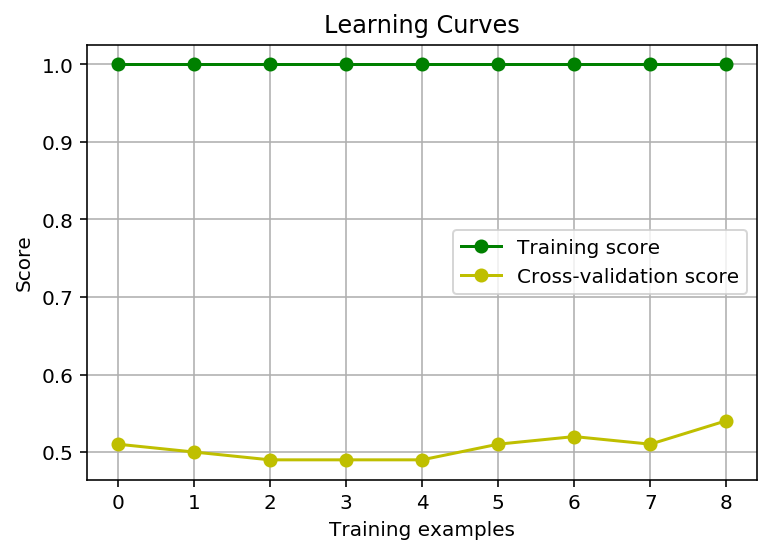

In [16]:
# Import, read, and split data
import pandas as pd
data = pd.read_csv('learning_curve_data.csv')
import numpy as np
X = np.array(data[['x1', 'x2']])
y = np.array(data['y'])

# Fix random seed
np.random.seed(55)

### Imports
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

# TODO: Uncomment one of the three classifiers, and hit "Test Run"
# to see the learning curve. Use these to answer the quiz below.

### Logistic Regression
# estimator = LogisticRegression()

### Decision Tree
#estimator = GradientBoostingClassifier()

### Support Vector Machine
estimator = SVC(kernel='rbf', gamma=1000)

from sklearn.model_selection import learning_curve

# It is good to randomize the data before drawing Learning Curves
def randomize(X, Y):
    permutation = np.random.permutation(Y.shape[0])
    X2 = X[permutation,:]
    Y2 = Y[permutation]
    return X2, Y2

X2, y2 = randomize(X, y)

def draw_learning_curves(X, y, estimator, num_trainings):
    import matplotlib.pyplot as plt
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X2, y2, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, num_trainings))

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.title("Learning Curves")
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    plt.plot(train_scores_mean, 'o-', color="g",
             label="Training score")
    plt.plot(test_scores_mean, 'o-', color="y",
             label="Cross-validation score")


    plt.legend(loc="best")

    plt.show()
draw_learning_curves(X, y, estimator, 9)

## We can observe from the curves that:

> <li>The Logistic Regression model has a low training and testing score.</li>
> <li>The Decision Tree model has a high training and testing score.</li>
> <li>The Support Vector Machine model has a high training score, and a low testing score.</li>


From here, we can determine that the Logistic Regression model underfits, the SVM model overfits, and the Decision Tree model is just right.
<img src='LCurveQuiz.png'>

Equivalently, we can flip this curves (as they measure score, and our original curves measure error), and compare them with the following three curves, we can see that they look a lot like the three curves we saw before. (Note: The fact that we flip the curves doesn't mean that the error is 1 minus the score. It only means that as the model gets better, the error decreases, and the score increases.)

<img src='LCurveFlip.png'>

Note the decision boundaries highlighting the issue:
<img src='DecisionBoundaries.png'>

<li>The Logistic Regression model uses a line, which is too simplistic. It doesn't do very well on the training set. Thus, it underfits.</li>
<li>The Decision Tree model uses a square, which is a pretty good fit, and generalizes well. Thus, this model is good.</li>
<li>The Support Vector Machine model actually draws a tiny circle around each point. This is clearly just memorizing the training set, and won't generalize well. Thus, it overfits.</li>

# Grid Search

We can use Grid Search to decide among a number of candidate models to select the model with the highest F1 score. Here we can see a grid search of SVM

<img src='GridSearch.png'>

## Implementing Grid Search with SKLearn

```python
from sklearn.model_selection import GridSearchCV
# select parameters
parameters = {'kernel': ['poly', 'rbf'], 'C':[0.1, 1, 10]}
# create a scorer
from sklearn.metrics import make_scorer, f1_score
scorer= make_scorer(f1_score)
# create gridsearch object
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)
# fit the data
grid_fit = grid_obj.fit(X, y)
# find the best estimator
best_clf = grid_fit.best_estimator_
```
Use this estimator, ```best_clf``` to make the predictions

# Grid Search mini-lab

## Improving a model with Grid Search

In this mini-lab, we'll fit a decision tree model to some sample data. This initial model will overfit heavily. Then we'll use Grid Search to find better parameters for this model, to reduce the overfitting.

First, some imports.

In [17]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### 1. Reading and plotting the data
Now, a function that will help us read the csv file, and plot the data.

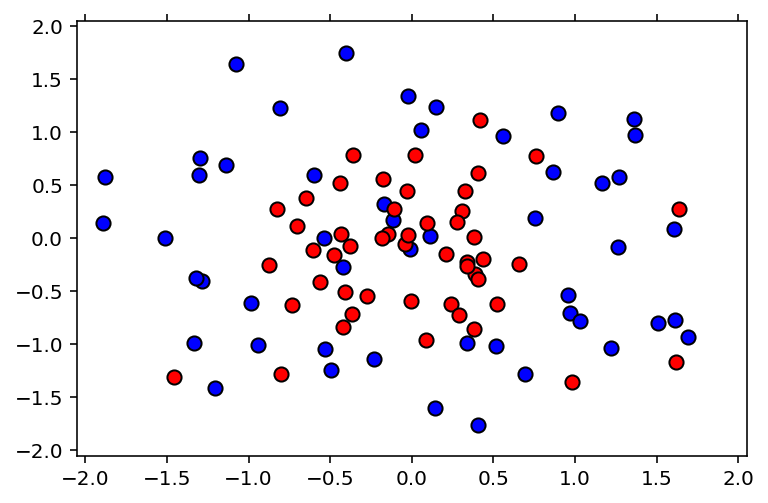

In [19]:
def load_pts(csv_name):
    data = np.asarray(pd.read_csv(csv_name, header=None))
    X = data[:,0:2]
    y = data[:,2]

    plt.scatter(X[np.argwhere(y==0).flatten(),0], X[np.argwhere(y==0).flatten(),1],s = 50, color = 'blue', edgecolor = 'k')
    plt.scatter(X[np.argwhere(y==1).flatten(),0], X[np.argwhere(y==1).flatten(),1],s = 50, color = 'red', edgecolor = 'k')
    
    plt.xlim(-2.05,2.05)
    plt.ylim(-2.05,2.05)
    plt.grid(False)
    plt.tick_params(
        axis='x',
        which='both',
        bottom='off',
        top='off')

    return X,y

X, y = load_pts('grid_search.csv')
plt.show()

### 2. Splitting our data into training and testing sets

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, make_scorer

#Fixing a random seed
import random
random.seed(42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 3. Fitting a Decision Tree model

In [21]:
from sklearn.tree import DecisionTreeClassifier

# Define the model (with default hyperparameters)
clf = DecisionTreeClassifier(random_state=42)

# Fit the model
clf.fit(X_train, y_train)

# Make predictions
train_predictions = clf.predict(X_train)
test_predictions = clf.predict(X_test)

Now let's plot the model, and find the testing f1_score, to see how we did.

The following function will help us plot the model.

In [22]:
def plot_model(X, y, clf):
    plt.scatter(X[np.argwhere(y==0).flatten(),0],X[np.argwhere(y==0).flatten(),1],s = 50, color = 'blue', edgecolor = 'k')
    plt.scatter(X[np.argwhere(y==1).flatten(),0],X[np.argwhere(y==1).flatten(),1],s = 50, color = 'red', edgecolor = 'k')

    plt.xlim(-2.05,2.05)
    plt.ylim(-2.05,2.05)
    plt.grid(False)
    plt.tick_params(
        axis='x',
        which='both',
        bottom='off',
        top='off')

    r = np.linspace(-2.1,2.1,300)
    s,t = np.meshgrid(r,r)
    s = np.reshape(s,(np.size(s),1))
    t = np.reshape(t,(np.size(t),1))
    h = np.concatenate((s,t),1)

    z = clf.predict(h)

    s = s.reshape((np.size(r),np.size(r)))
    t = t.reshape((np.size(r),np.size(r)))
    z = z.reshape((np.size(r),np.size(r)))

    plt.contourf(s,t,z,colors = ['blue','red'],alpha = 0.2,levels = range(-1,2))
    if len(np.unique(z)) > 1:
        plt.contour(s,t,z,colors = 'k', linewidths = 2)
    plt.show()

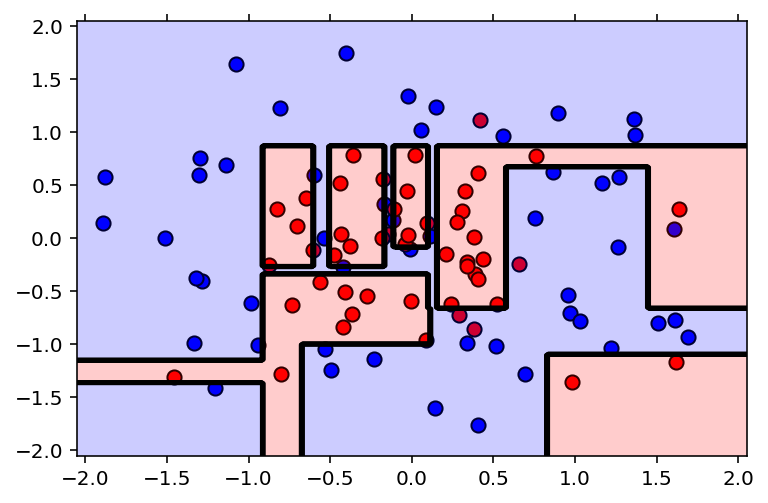

The Training F1 Score is 1.0
The Testing F1 Score is 0.7000000000000001


In [23]:
plot_model(X, y, clf)
print('The Training F1 Score is', f1_score(train_predictions, y_train))
print('The Testing F1 Score is', f1_score(test_predictions, y_test))

Woah! Some heavy overfitting there. Not just from looking at the graph, but also from looking at the difference between the high training score (1.0) and the low testing score (0.7).Let's see if we can find better hyperparameters for this model to do better. We'll use grid search for this.

### 4. (TODO) Use grid search to improve this model.

In here, we'll do the following steps:
1. First define some parameters to perform grid search on. We suggest to play with `max_depth`, `min_samples_leaf`, and `min_samples_split`.
2. Make a scorer for the model using `f1_score`.
3. Perform grid search on the classifier, using the parameters and the scorer.
4. Fit the data to the new classifier.
5. Plot the model and find the f1_score.
6. If the model is not much better, try changing the ranges for the parameters and fit it again.

**_Hint:_ If you're stuck and would like to see a working solution, check the solutions notebook in this same folder.**

/Users/daiglechris/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


The training F1 Score is 0.8148148148148148
The testing F1 Score is 0.8


/Users/daiglechris/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


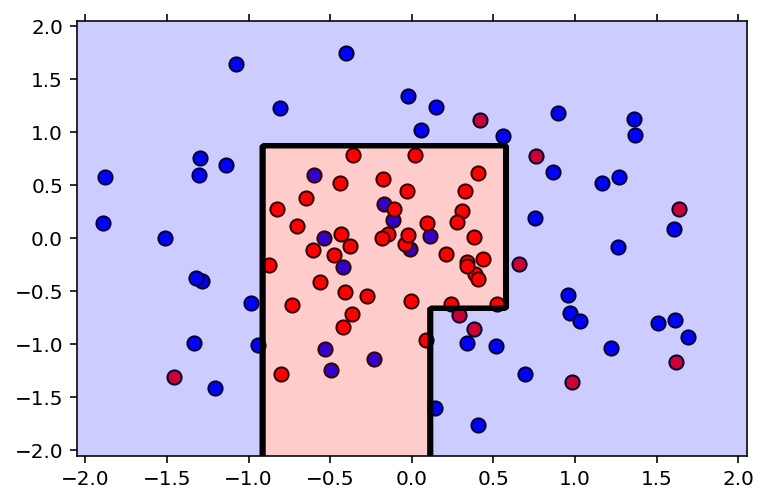

In [25]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

clf = DecisionTreeClassifier(random_state=42)

# Create the parameters list you wish to tune.
parameters = {'max_depth':[2,4,6,8,10],'min_samples_leaf':[2,4,6,8,10], 'min_samples_split':[2,4,6,8,10]}

# Make an fbeta_score scoring object.
scorer = make_scorer(f1_score)

# Perform grid search on the classifier using 'scorer' as the scoring method.
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters.
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator.
best_clf = grid_fit.best_estimator_

# Fit the new model.
best_clf.fit(X_train, y_train)

# Make predictions using the new model.
best_train_predictions = best_clf.predict(X_train)
best_test_predictions = best_clf.predict(X_test)

# Calculate the f1_score of the new model.
print('The training F1 Score is', f1_score(best_train_predictions, y_train))
print('The testing F1 Score is', f1_score(best_test_predictions, y_test))

# Plot the new model.
plot_model(X, y, best_clf)

# Let's also explore what parameters ended up being used in the new model.
best_clf
plt.show()

### 5. Conclusion
Note that by using GridSearch we improved the F1 Score from 0.7 to 0.8 (and we lost some training score, but this is ok). Also, if you look at the plot, the second model has a much simpler boundary, which implies that it's less likely to overfit.

# Diabetes Case Study

You now have had the opportunity to work with a range of supervised machine learning techniques for both classification and regression.  Before you apply these in the project, let's do one more example to see how the machine learning process works from beginning to end with another popular dataset.

We will start out by reading in the dataset and our necessary libraries.  You will then gain an understanding of how to optimize a number of models using grid searching as you work through the notebook. 

In [14]:
# Import our libraries
import pandas as pd
import numpy as np
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import seaborn as sns
sns.set(style="ticks")

import check_file as ch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Read in our dataset
diabetes = pd.read_csv('diabetes.csv')

# Take a look at the first few rows of the dataset
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Because this course has been aimed at understanding machine learning techniques, we have largely ignored items related to parts of the data analysis process that come before building machine learning models - exploratory data analysis, feature engineering, data cleaning, and data wrangling.  

> **Step 1:** Let's do a few steps here.  Take a look at some of usual summary statistics calculated to accurately match the values to the appropriate key in the dictionary below. 

In [15]:
diabetes.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


/Users/daiglechris/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/daiglechris/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


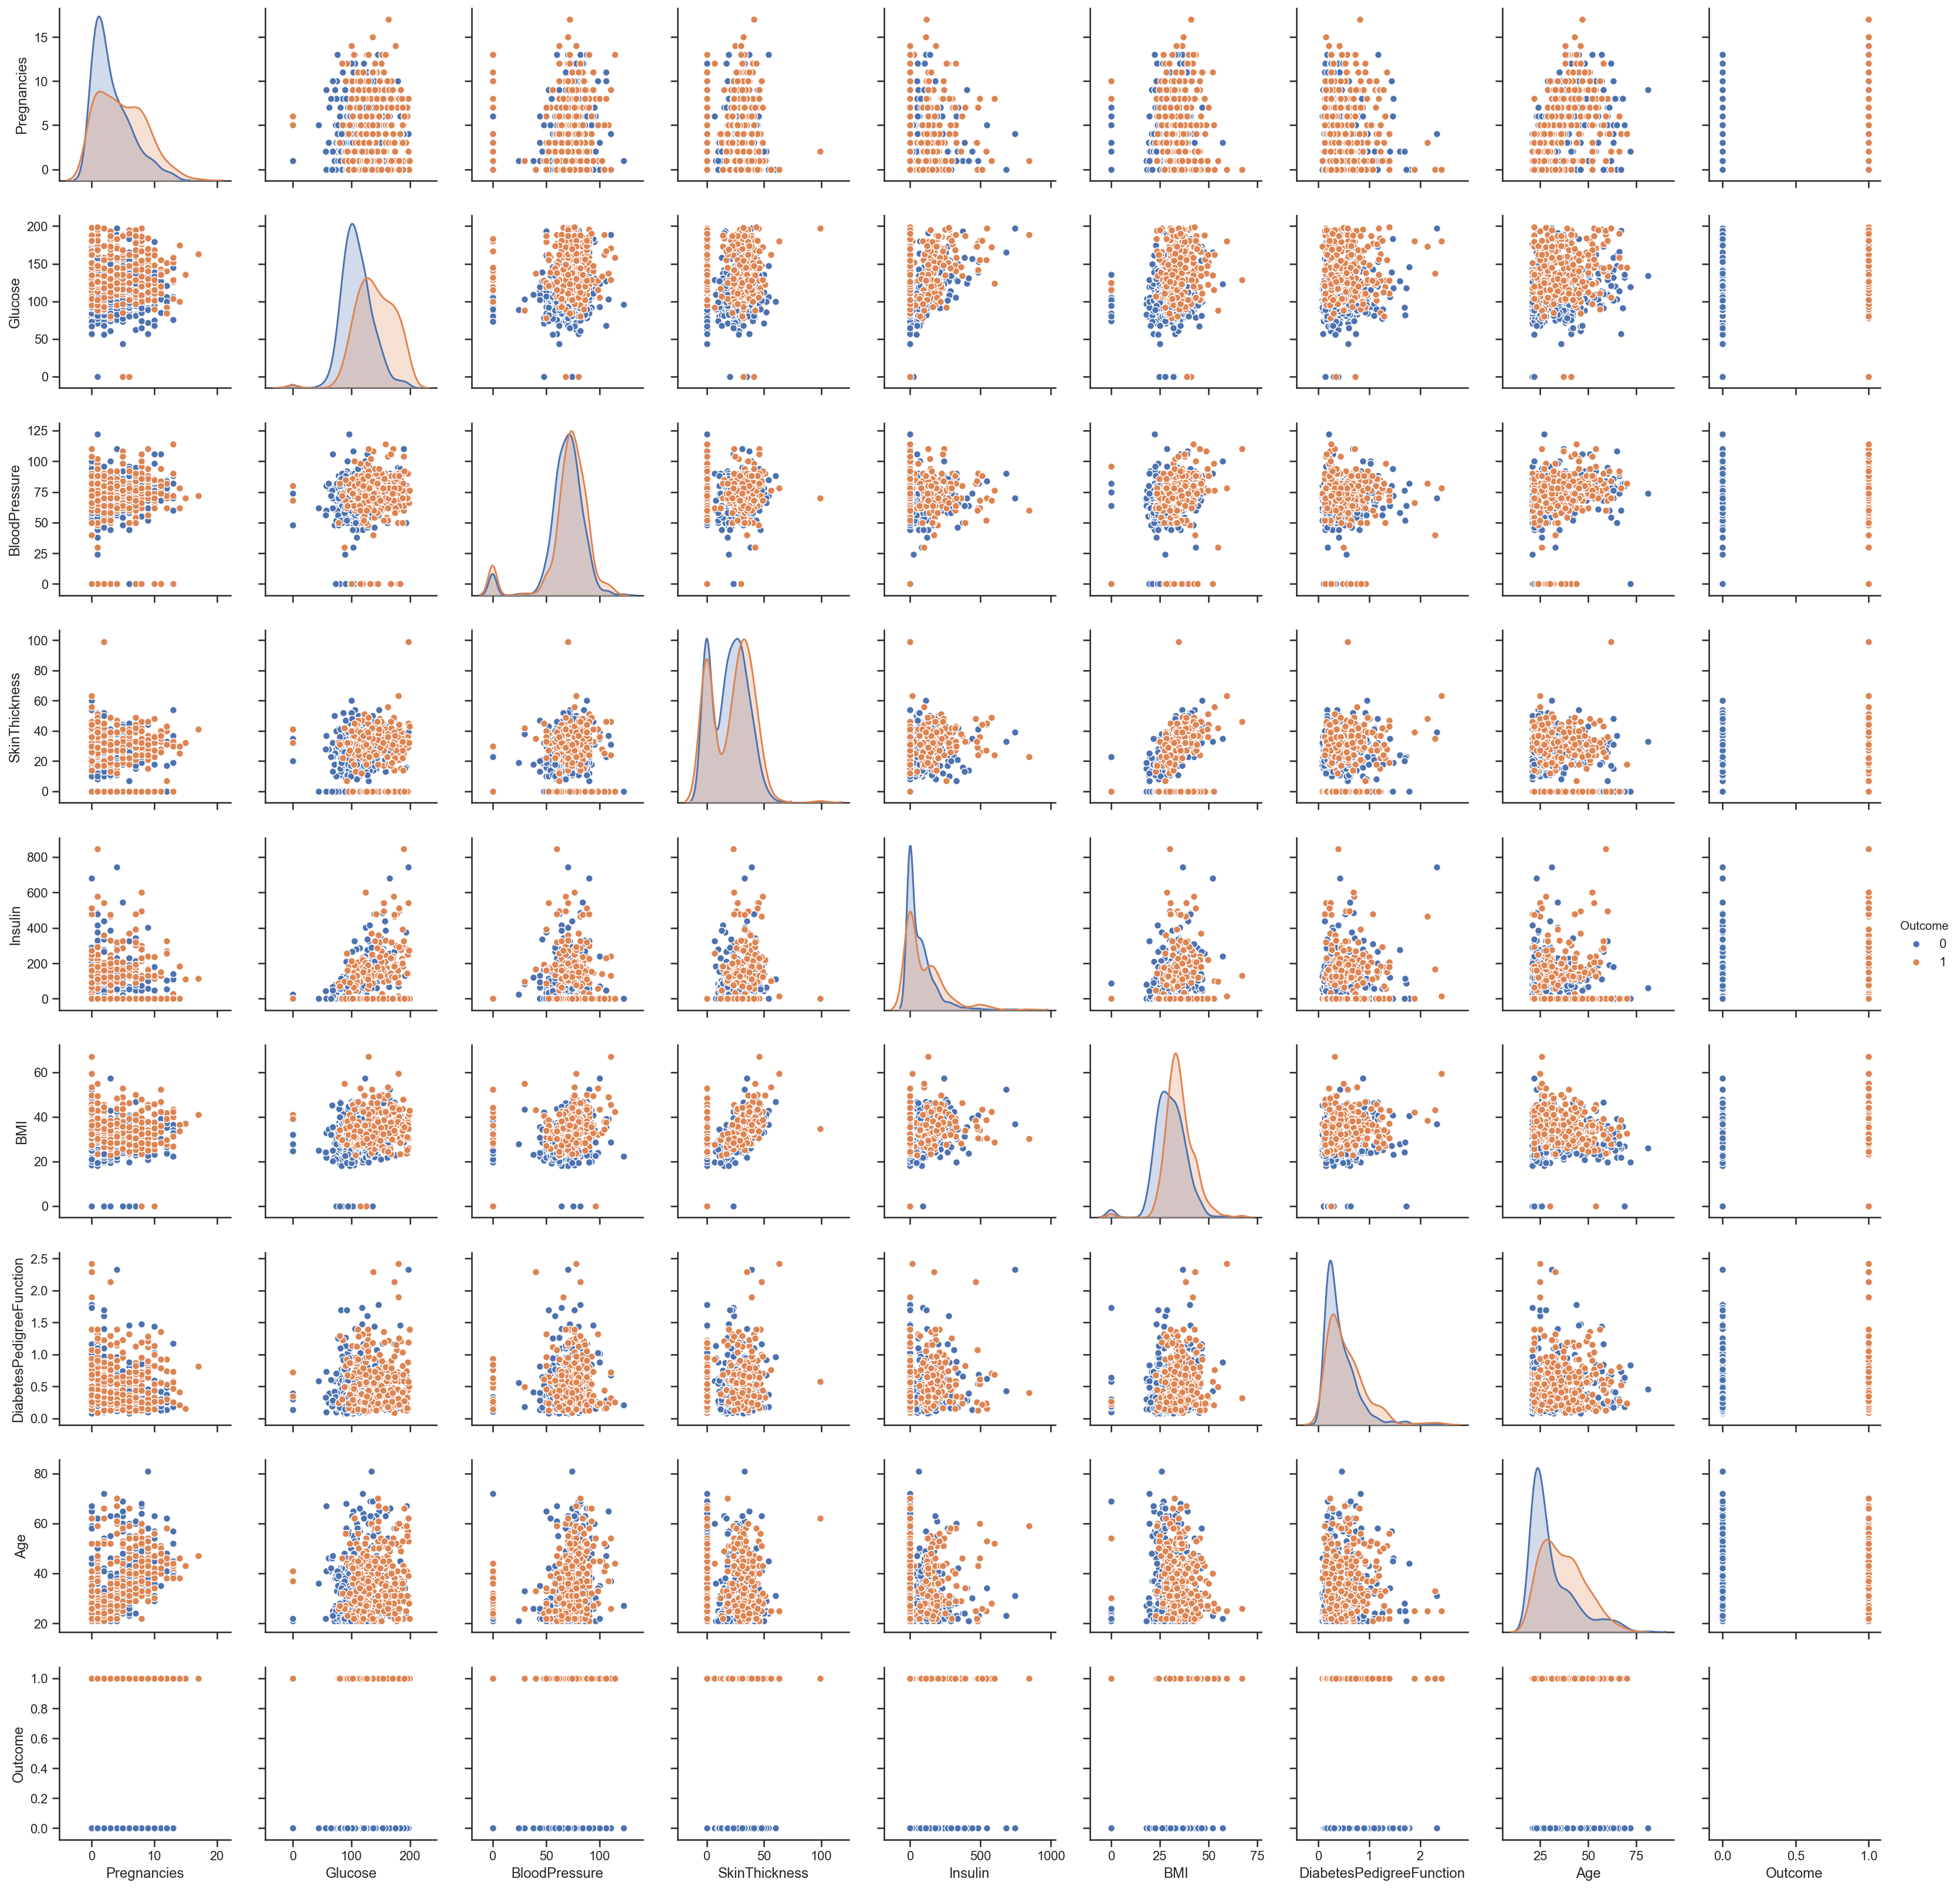

In [16]:
sns.pairplot(diabetes, hue="Outcome")
plt.show()

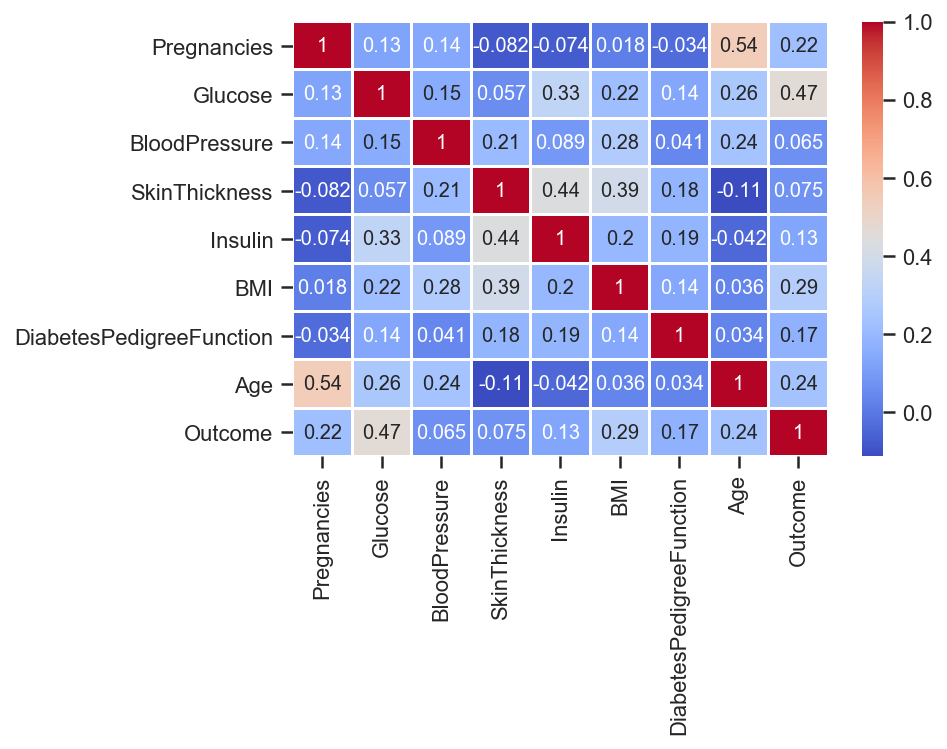

In [17]:
sns.heatmap(diabetes.corr(), annot=True, cmap="coolwarm", linecolor='white', linewidths=1)
plt.show()

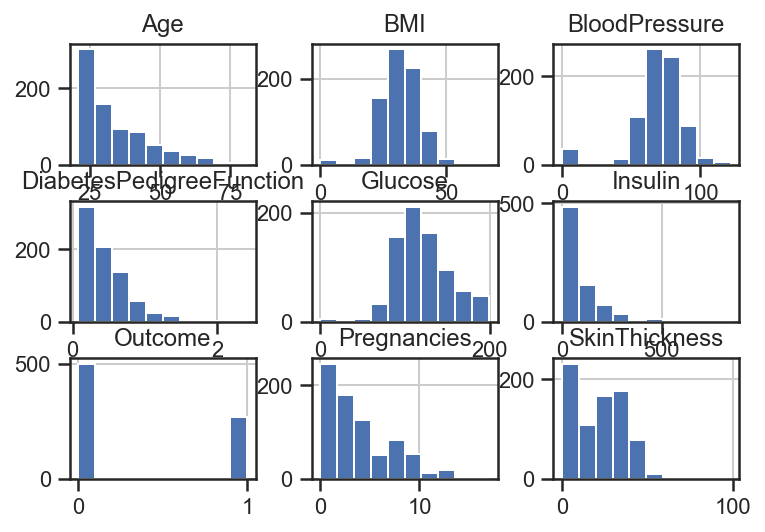

In [18]:
diabetes.hist()
plt.show()

In [19]:
# Possible keys for the dictionary
a = '0.65'
b = '0'
c = 'Age'
d = '0.35'
e = 'Glucose'
f = '0.5'
g = "More than zero"

# Fill in the dictionary with the correct values here
answers_one = {
    'The proportion of diabetes outcomes in the dataset': d,
    'The number of missing data points in the dataset': b,
    'A dataset with a symmetric distribution': e,
    'A dataset with a right-skewed distribution': c, 
    'This variable has the strongest correlation with the outcome': e
}

# Just to check your answer, don't change this
ch.check_one(answers_one)

Awesome! These all look great!


> **Step 2**: Since our dataset here is quite clean, we will jump straight into the machine learning.  Our goal here is to be able to predict cases of diabetes.  First, you need to identify the y vector and X matrix.  Then, the following code will divide your dataset into training and test data.   

In [20]:
y = diabetes['Outcome']
X = diabetes[['Pregnancies','Glucose', 'BloodPressure', 'SkinThickness','Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Now that you have a training and testing dataset, we need to create some models that and ultimately find the best of them.  However, unlike in earlier lessons, where we used the defaults, we can now tune these models to be the very best models they can be.

It can often be difficult (and extremely time consuming) to test all the possible hyperparameter combinations to find the best models.  Therefore, it is often useful to set up a randomized search.  

In practice, randomized searches across hyperparameters have shown to be more time confusing, while still optimizing quite well.  One article related to this topic is available [here](https://blog.h2o.ai/2016/06/hyperparameter-optimization-in-h2o-grid-search-random-search-and-the-future/).  The documentation for using randomized search in sklearn can be found [here](http://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html#sphx-glr-auto-examples-model-selection-plot-randomized-search-py) and [here](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

In order to use the randomized search effectively, you will want to have a pretty reasonable understanding of the distributions that best give a sense of your hyperparameters.  Understanding what values are possible for your hyperparameters will allow you to write a grid search that performs well (and doesn't break).

> **Step 3**: In this step, I will show you how to use randomized search, and then you can set up grid searches for the other models in Step 4.  However, you will be helping, as I don't remember exactly what each of the hyperparameters in SVMs do.  Match each hyperparameter to its corresponding tuning functionality.



In [21]:
# build a classifier
clf_rf = RandomForestClassifier()

# Set up the hyperparameter search
param_dist = {"max_depth": [3, None],
              "n_estimators": list(range(10, 200)),
              "max_features": list(range(1, X_test.shape[1]+1)),
              "min_samples_split": list(range(2, 11)),
              "min_samples_leaf": list(range(1, 11)),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}


# Run a randomized search over the hyperparameters
random_search = RandomizedSearchCV(clf_rf, param_distributions=param_dist)

# Fit the model on the training data
random_search.fit(X_train, y_train)

# Make predictions on the test data
rf_preds = random_search.best_estimator_.predict(X_test)

ch.print_metrics(y_test, rf_preds, 'random forest')

/Users/daiglechris/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Accuracy score for random forest : 0.7727272727272727
Precision score random forest : 0.6785714285714286
Recall score random forest : 0.6909090909090909
F1 score random forest : 0.6846846846846847





> **Step 4**: Now that you have seen how to run a randomized grid search using random forest, try this out for the AdaBoost and SVC classifiers.  You might also decide to try out other classifiers that you saw earlier in the lesson to see what works best.

In [22]:
# build a classifier for ada boost
clf_ada = AdaBoostClassifier()

# Set up the hyperparameter search
# look at  setting up your search for n_estimators, learning_rate
# http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
param_dist = {"n_estimators": [10, 100, 200, 400],
              "learning_rate": [0.001, 0.005, .01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 2, 10, 20]}


# Run a randomized search over the hyperparameters
ada_search = RandomizedSearchCV(clf_ada, param_distributions=param_dist)

# Fit the model on the training data
ada_search.fit(X_train, y_train)

# Make predictions on the test data
ada_preds = ada_search.best_estimator_.predict(X_test)

ch.print_metrics(y_test, ada_preds, 'adaboost')

/Users/daiglechris/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Accuracy score for adaboost : 0.7662337662337663
Precision score adaboost : 0.6862745098039216
Recall score adaboost : 0.6363636363636364
F1 score adaboost : 0.660377358490566





In [24]:
# Takes a long time

# build a classifier for support vector machines
clf_svc = SVC()

# Set up the hyperparameter search
# look at setting up your search for C (recommend 0-10 range), 
# kernel, and degree
# http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
param_dist = {"C": [0.1, 0.5, 1, 3, 5],
              "kernel": ['linear','rbf']
             }


# Run a randomized search over the hyperparameters
svc_search = RandomizedSearchCV(clf_svc, param_distributions=param_dist, cv=5)

# Fit the model on the training data
svc_search.fit(X_train, y_train)

# Make predictions on the test data
svc_preds = svc_search.best_estimator_.predict(X_test)

ch.print_metrics(y_test, svc_preds, 'svc')

/Users/daiglechris/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/daiglechris/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/daiglechris/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/daiglechris/anaconda3/lib/pyth

Accuracy score for svc : 0.7532467532467533
Precision score svc : 0.6545454545454545
Recall score svc : 0.6545454545454545
F1 score svc : 0.6545454545454545





> **Step 5**: Use the test below to see if your best model matched, what we found after running the grid search.  

In [26]:
a = 'randomforest'
b = 'adaboost'
c = 'supportvector'

best_model = b # put your best model here as a string or variable

ch.check_best(best_model)

Nice!  It looks like your best model matches the best model I found as well!  It makes sense to use f1 score to determine best in this case given the imbalance of classes.  There might be justification for precision or recall being the best metric to use as well - precision showed to be best with adaboost again.  With recall, SVMs proved to be the best for our models.


Once you have found your best model, it is also important to understand why it is performing well.  In regression models where you can see the weights, it can be much easier to interpret results. 

> **Step 6**:  Despite the fact that your models here are more difficult to interpret, there are some ways to get an idea of which features are important.  Using the "best model" from the previous question, find the features that were most important in helping determine if an individual would have diabetes or not. Do your conclusions match what you might have expected during the exploratory phase of this notebook?

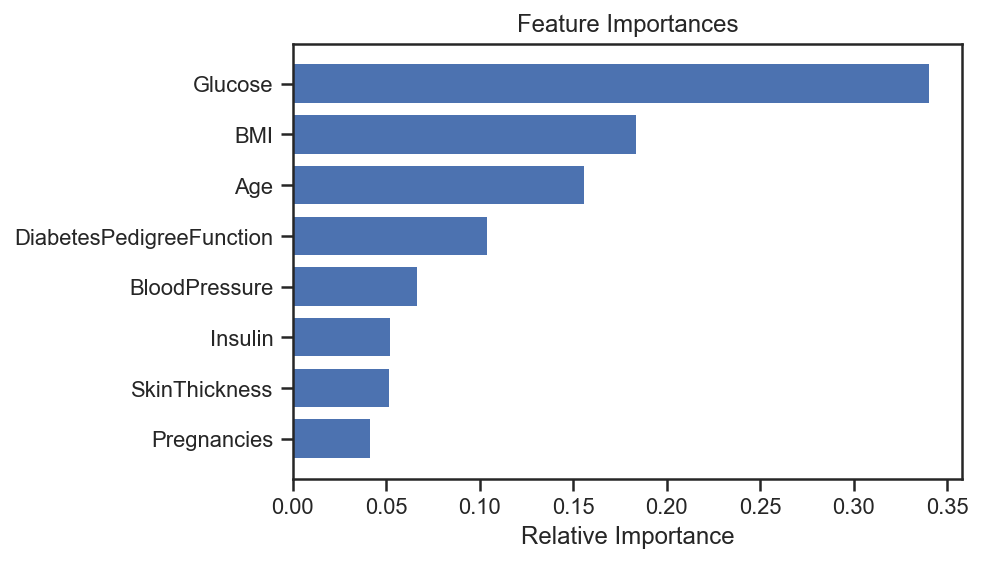

In [27]:
# Show your work here - the plot below was helpful for me
# https://stackoverflow.com/questions/44101458/random-forest-feature-importance-chart-using-python

features = diabetes.columns[:diabetes.shape[1]]
importances = random_search.best_estimator_.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance');

**For the most part these match what I would expect based on the correlations we saw earlier between each variable and Outcome.  However, one interesting finding is that pregnancy looked to be correlated with the Outcome in the exploratory findings.  Though, that is likely only because pregnancy is correlated with age, and age is truly the variable that is a better indicator of diabetes.**

> **Step 7**:  Using your results above to complete the dictionary below.

In [28]:
# Check your solution by matching the correct values in the dictionary
# and running this cell
a = 'Age'
b = 'BloodPressure'
c = 'BMI'
d = 'DiabetesPedigreeFunction'
e = 'Insulin'
f = 'Glucose'
g = 'Pregnancy'
h = 'SkinThickness'



sol_seven = {
    'The variable that is most related to the outcome of diabetes' : f,
    'The second most related variable to the outcome of diabetes' : c,
    'The third most related variable to the outcome of diabetes' : a,
    'The fourth most related variable to the outcome of diabetes' : d
}

ch.check_q_seven(sol_seven)

That's right!  Some of these were expected, but some were a bit unexpected too!


> **Step 8**:  Now provide a summary of what you did through this notebook, and how you might explain the results to a non-technical individual.  When you are done, check out the solution notebook by clicking the orange icon in the upper left.

**In this case study, we looked at predicting diabetes for 768 patients.  There was a reasonable amount of class imbalance with just under 35% of patients having diabetes.  There were no missing data, and initial looks at the data showed it would be difficult to separate patients with diabetes from those that did not have diabetes.**

**Three advanced modeling techniques were used to predict whether or not a patient has diabetes.  The most successful of these techniques proved to be an AdaBoost Classification technique, which had the following metrics:**

Accuracy score for adaboost : 0.7792207792207793

Precision score adaboost : 0.7560975609756098

Recall score adaboost : 0.5636363636363636

F1 score adaboost : 0.6458333333333333


**Based on the initial look at the data, it is unsurprising that `Glucose`, `BMI`, and `Age` were important in understanding if a patient has diabetes.  These were consistent with more sophisticated approaches.  Interesting findings were that pregnancy looked to be correlated when initially looking at the data.  However, this was likely due to its large correlation with age.**